# Defining subdomains for different materials
Author: Jørgen S. Dokken

Solving PDEs in domains made up of different materials is frequently encountered task. In FEniCS-X, we handle these problems by defining a Discontinous cell-wise constant function.
Such a function can be created over any mesh in the following way
## Subdomains on built-in meshes

In [1]:
import dolfinx
from mpi4py import MPI

mesh = dolfinx.UnitSquareMesh(MPI.COMM_WORLD, 10, 10)
Q = dolfinx.FunctionSpace(mesh, ("DG", 0))

We will use a simple example with two materials in two dimensions to demonstrate the idea. The whole domain will be $\Omega=[0,1]\times[0,1]$, which consists of two subdomains 
$\Omega_0=[0,1]\times [0,1/2]$ and $\Omega_1=[0,1]\times[1/2, 1]$. We start by creating two python functions, where each returns `True` if the input coordinate is inside its domain.

In [2]:
import numpy as np
def Omega_0(x):
    return x[1] <= 0.5

def Omega_1(x):
    return x[1] >= 0.5

We will solve a variable-coefficient extension of the Poisson equation
```{math}
-\nabla \cdot [\kappa (x,y)\nabla u(x, y)]&= 1 && \text{in } \Omega,\\
u&=u_D=1 && \text{on } \partial\Omega_D=[0,y], y\in[0,1]\\
-\frac{\partial u}{\partial}{n}=0 && \text{on } \partial\Omega\setminus \partial\Omega_D
```
Our next step is to define $\kappa$

In [3]:
kappa = dolfinx.Function(Q)
cells_0 = dolfinx.mesh.locate_entities(mesh, mesh.topology.dim, Omega_0)
cells_1 = dolfinx.mesh.locate_entities(mesh, mesh.topology.dim, Omega_1)



In the previous code block, we found which cells (triangular elements) which satisfies the condition for being in $\Omega_0, \Omega_1$. As the $DG-0$ function contain only one degree of freedom per mesh, there is a one to one mapping between the cell indicies and the degrees of freedom. We let $\kappa=\begin{cases}
1 \text{ if } x\in\Omega_0\\
0.1 \text{ if } x\in\Omega_1\\
\end{cases}$

In [4]:
with kappa.vector.localForm() as loc:
    loc.setValues(cells_0, np.full(len(cells_0), 1))
    loc.setValues(cells_1, np.full(len(cells_1), 0.1))

We are now ready to define our variational formulation and  Dirichlet boundary condition after using integration by parts 

In [5]:
import ufl
from petsc4py import PETSc
V = dolfinx.FunctionSpace(mesh, ("CG", 1))
u, v = ufl.TrialFunction(V), ufl.TestFunction(V)
a = ufl.inner(kappa*ufl.grad(u), ufl.grad(v))*ufl.dx
x = ufl.SpatialCoordinate(mesh)
L = dolfinx.Constant(mesh, 1) * v * ufl.dx
dofs = dolfinx.fem.locate_dofs_geometrical(V, lambda x: np.isclose(x[0], 0))
u_D = dolfinx.Function(V)
with u_D.vector.localForm() as loc:
    loc.setValues(dofs, np.full(len(dofs), 1))
bcs = [dolfinx.DirichletBC(u_D, dofs)]

We can now solve and visualize the solution of the problem

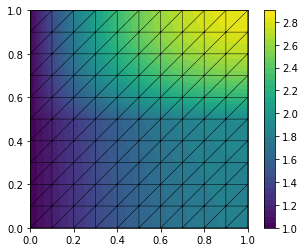

In [6]:
A = dolfinx.fem.assemble_matrix(a, bcs=bcs)
A.assemble()
b = dolfinx.fem.assemble_vector(L)
dolfinx.fem.apply_lifting(b, [a], [bcs])
b.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES,mode=PETSc.ScatterMode.REVERSE)
dolfinx.fem.set_bc(b, bcs)

uh = dolfinx.Function(V)
solver = PETSc.KSP().create(MPI.COMM_WORLD)
solver.setType(PETSc.KSP.Type.PREONLY)
solver.getPC().setType(PETSc.PC.Type.LU)
solver.setOperators(A)
solver.solve(b, uh.vector)
uh.vector.ghostUpdate(addv=PETSc.InsertMode.INSERT_VALUES,mode=PETSc.ScatterMode.FORWARD)

import dolfinx.plotting
import matplotlib.pyplot as plt
c = dolfinx.plotting.plot(uh)
dolfinx.plotting.plot(mesh, color="k", linewidth=0.5)
plt.colorbar(c)

We clearly observe different behavior in the two regions, whose both has the same Dirichlet boundary condition on the left side, where $x=0$.

## Subdomains defined from external mesh data
Let us now consider the same problem, but using GMSH to generate the mesh and subdomains. We will then in turn show how to use this data to generate discontinuous functions in dolfin-X.

In [7]:
import gmsh
gmsh.initialize()
proc = MPI.COMM_WORLD.rank 
top_marker = 2
bottom_marker = 1
left_marker = 1
if proc == 0:
    # We create one rectangle for each subdomain
    gmsh.model.occ.addRectangle(0, 0, 0, 1, 0.5, tag=1)
    gmsh.model.occ.addRectangle(0, 0.5, 0, 1, 0.5, tag=2)
    # We fuse the two rectangles and keep the interface between them 
    gmsh.model.occ.fragment([(2,1)],[(2,2)])
    gmsh.model.occ.synchronize()
   
    # Mark the top (2) and bottom (1) rectangle
    top, bottom = None, None
    for surface in gmsh.model.getEntities(dim=2):
        com = gmsh.model.occ.getCenterOfMass(surface[0], surface[1])
        if np.allclose(com, [0.5,0.25, 0]):
            bottom = surface[1]
        else:
            top = surface[1]
    gmsh.model.addPhysicalGroup(2, [bottom], bottom_marker)
    gmsh.model.addPhysicalGroup(2, [top], top_marker)
    # Tag the left boundary
    left = []
    for line in gmsh.model.getEntities(dim=1):
        com = gmsh.model.occ.getCenterOfMass(line[0], line[1])
        if np.isclose(com[0], 0):
            left.append(line[1])
    gmsh.model.addPhysicalGroup(1, left, left_marker)
    gmsh.model.mesh.generate(2)
    gmsh.write("mesh.msh")
gmsh.finalize()

We will use `meshio` to read in the `msh` file, and convert it to a more suitable IO format. Meshio requires `h54py`, and can be installed on linux with the following commands:
```{code}
export HDF5_MPI="ON"
export CC=mpicc
export HDF5_DIR="/usr/lib/x86_64-linux-gnu/hdf5/mpich/"
pip3 install --no-cache-dir --no-binary=h5py h5py meshio
```

In [8]:
import meshio
if proc == 0:
    # Read in mesh
    msh = meshio.read("mesh.msh")
    # Gather all cells from each type
    triangle_cells = []
    line_cells = []
    for cell in msh.cells:
        if cell.type == "line":
            line_cells.append(cell.data)
        elif cell.type == "triangle":
            triangle_cells.append(cell.data)
    # Gather mesh data
    entity_data = msh.cell_data_dict["gmsh:physical"]
    triangle_data = np.hstack([entity_data[key] for key in entity_data.keys() if key=="triangle"])
    line_data = np.hstack([entity_data[key] for key in entity_data.keys() if key=="line"])
    triangle_cells = np.vstack(triangle_cells)
    line_cells = np.vstack(line_cells)
    # Create and save one file for the mesh, and one file for the facets    
    gdim = 2
    triangle_mesh = meshio.Mesh(msh.points[:,:gdim], [("triangle", triangle_cells)], cell_data={"triangle_data": [triangle_data]})
    line_mesh = meshio.Mesh(msh.points[:,:gdim], [("line", line_cells)], cell_data={"line_data": [entity_data["line"]]})
    meshio.write("mesh.xdmf", triangle_mesh)
    meshio.write("mt.xdmf", line_mesh)

Note that we have generated and written the mesh on only one processor. However, the `xdmf`-format supports parallel IO, and we can thus read the mesh in parallel.

In [9]:
import dolfinx.io
with dolfinx.io.XDMFFile(MPI.COMM_WORLD, "mesh.xdmf", "r") as xdmf:
    mesh = xdmf.read_mesh(name="Grid")
    ct = xdmf.read_meshtags(mesh, name="Grid")
mesh.topology.create_connectivity(mesh.topology.dim, mesh.topology.dim-1)
with dolfinx.io.XDMFFile(MPI.COMM_WORLD, "mt.xdmf", "r") as xdmf:
    ft = xdmf.read_meshtags(mesh, name="Grid")

We have now read in the mesh and corresponding cell and facet data. We can now create our discontinuous function `kappa` as follows

In [10]:
Q = dolfinx.FunctionSpace(mesh, ("DG", 0))
kappa = dolfinx.Function(Q)
with kappa.vector.localForm() as loc:
    bottom_cells = ct.indices[ct.values==bottom_marker]
    loc.setValues(bottom_cells, np.full(len(bottom_cells), 1))
    top_cells = ct.indices[ct.values==top_marker]
    loc.setValues(top_cells, np.full(len(top_cells), 0.1))

We can also efficiently use the facet data `ft` to create the Dirichlet boundary condition

In [11]:
V = dolfinx.FunctionSpace(mesh, ("CG", 1))
u_bc = dolfinx.Function(V)
left_facets = ft.indices[ft.values==left_marker]
left_dofs = dolfinx.fem.locate_dofs_topological(V, mesh.topology.dim-1, left_facets)
with u_bc.vector.localForm() as loc:
    loc.setValues(left_dofs, np.full(len(left_dofs), 1))
bcs = [dolfinx.DirichletBC(u_bc, left_dofs)]

We can now solve the problem in a similar fashion as above

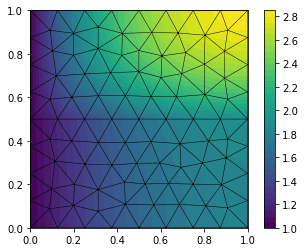

In [12]:
import ufl
from petsc4py import PETSc
u, v = ufl.TrialFunction(V), ufl.TestFunction(V)
a = ufl.inner(kappa*ufl.grad(u), ufl.grad(v))*ufl.dx
x = ufl.SpatialCoordinate(mesh)
L = dolfinx.Constant(mesh, 1) * v * ufl.dx
A = dolfinx.fem.assemble_matrix(a, bcs=bcs)
A.assemble()
b = dolfinx.fem.assemble_vector(L)
dolfinx.fem.apply_lifting(b, [a], [bcs])
b.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES,mode=PETSc.ScatterMode.REVERSE)
dolfinx.fem.set_bc(b, bcs)

uh = dolfinx.Function(V)
solver = PETSc.KSP().create(MPI.COMM_WORLD)
solver.setType(PETSc.KSP.Type.PREONLY)
solver.getPC().setType(PETSc.PC.Type.LU)
solver.setOperators(A)
solver.solve(b, uh.vector)
uh.vector.ghostUpdate(addv=PETSc.InsertMode.INSERT_VALUES,mode=PETSc.ScatterMode.FORWARD)
import dolfinx.plotting
import matplotlib.pyplot as plt
c = dolfinx.plotting.plot(uh)
dolfinx.plotting.plot(mesh, color="k", linewidth=0.5)
plt.colorbar(c)